<a href="https://colab.research.google.com/github/eriosta/neuro/blob/main/Hierarchical_Clustering_of_Spatial_Correlation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hierarchical Clustering of Spatial Correlation

## Overview:
This notebook is designed to analyze and visualize the correlations between different components of fMRI data. Specifically, it focuses on the relationships between low-order and high-order components of the functional magnetic resonance imaging data. The provided code imports necessary libraries and datasets, defines classes and functions to perform the decompositions of the images into components, compute their correlations, and visualize these correlations effectively. Furthermore, an optimization mechanism is implemented to find the most optimal pair of components based on cumulative positive correlations.

## Objectives:

1. Decomposition of fMRI Data: The notebook uses the DictLearning method from the nilearn library to decompose the fMRI data into specified low-order and high-order components.

2. Correlation Analysis: Once decomposed, the code calculates the Pearson correlation coefficient between each pair of low-order and high-order components. Correlation significance is tested, and only significant values are stored.

3. Optimization of Components: The notebook seeks to determine the most optimal numbers of low and high components by calculating cumulative positive correlations for various combinations and identifying the best combination.

4. Visualization of Results: The results of the correlation analysis are visualized using bar plots and heatmaps, helping users better understand the relationships between the components.

5. Exporting Data: Besides visualization, the notebook also exports the computed correlation results to a CSV file, facilitating further analysis or reporting.

In [9]:
!pip install -q nilearn
import numpy as np
import matplotlib.pyplot as plt
from nilearn import datasets
from nilearn.decomposition import DictLearning
from nilearn import plotting, image
from scipy.stats import pearsonr
from nilearn import datasets, image
from nilearn.decomposition import DictLearning
import matplotlib.pyplot as plt

## Grid Search for Optimal N

Enter the minimum value for the range: 5
Enter the maximum value for the range: 20
Enter the significance level (default is 0.05): 0.01


Calculating Correlations:  33%|█████████████                          | 2/6 [02:58<04:53, 73.44s/it]/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
Calculating Correlations:  67%|██████████████████████████             | 4/6 [03:11<00:55, 27.90s/it]/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
Calculating Correlations:  83%|████████████████████████████████▌      | 5/6 [03:13<00:18, 18.65s/it]/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
Calculating Correlations: 100%|███████████████████████████


Average time per combination: 35.49s
Estimated total time: 212.93s
Optimal N-low: 15, N-high: 20, with cumulative r: 78.270


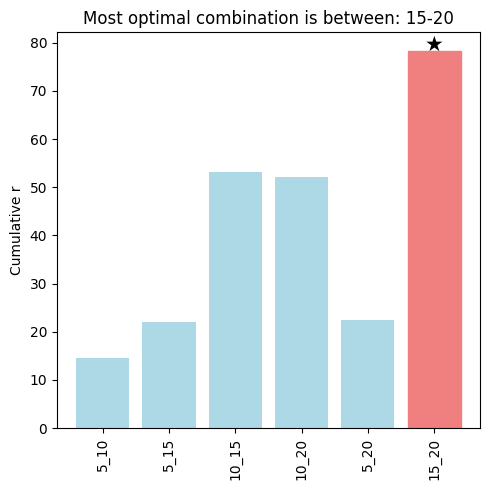

In [14]:
import numpy as np
import warnings
from nilearn import datasets
from nilearn.decomposition import DictLearning
from scipy.stats import pearsonr
import concurrent.futures
from tqdm import tqdm
import time

warnings.simplefilter(action='ignore', category=FutureWarning)

class ComponentCorrelationCalculator:
    """
    Class to calculate and analyze the correlation between components of fMRI data.

    Attributes:
    -----------
    n_low_order : int
        Number of low order components.
    n_high_order : int
        Number of high order components.
    func_filenames : list
        List of filenames of functional images.
    alpha : float
        Significance level for statistical testing.
    """
    def __init__(self, n_low_order, n_high_order, func_filenames, alpha=0.05):
        """
        Initialize the ComponentCorrelationCalculator with the given parameters.

        Parameters:
        -----------
        n_low_order : int
            Number of low order components to decompose.
        n_high_order : int
            Number of high order components to decompose.
        func_filenames : list
            List of filenames of functional images.
        alpha : float, optional
            Significance level for statistical testing. Default is 0.05.
        """
        self.n_low_order = n_low_order
        self.n_high_order = n_high_order
        self.func_filenames = func_filenames
        self.alpha = alpha

    def perform_decomposition(self):
        """ Decompose the functional images into specified number of components. """
        dict_learn_low = DictLearning(n_components=self.n_low_order, random_state=0)
        self.components_img_low = dict_learn_low.fit_transform(self.func_filenames)

        dict_learn_high = DictLearning(n_components=self.n_high_order, random_state=0)
        self.components_img_high = dict_learn_high.fit_transform(self.func_filenames)

    def compute_correlation_matrix(self):
        """ Compute the correlation matrix by correlating the low order and high order components. """
        self.correlation_matrix = np.zeros((self.n_low_order, self.n_high_order))

        for i in range(self.n_low_order):
            for j in range(self.n_high_order):
                data_low = self.components_img_low[0][..., i]
                data_high = self.components_img_high[0][..., j]
                correlation, p_value = pearsonr(data_low.ravel(), data_high.ravel())

                if p_value < self.alpha:
                    self.correlation_matrix[i, j] = correlation

        self.correlation_matrix = np.nan_to_num(self.correlation_matrix)

    def calculate_component_correlation(self):
        """ Compute the total positive correlations and return the results. """
        self.perform_decomposition()
        self.compute_correlation_matrix()
        positive_r = self.correlation_matrix[self.correlation_matrix > 0].sum()
        return self.n_low_order, self.n_high_order, positive_r

def optimize_components(n_low_range, n_high_range, func_filenames, alpha):
    """
    Function to optimize the number of components based on cumulative positive correlations.

    Parameters:
    -----------
    n_low_range : range
        Range of possible low order components.
    n_high_range : range
        Range of possible high order components.
    func_filenames : list
        List of filenames of functional images.
    alpha : float
        Significance level for statistical testing.

    Returns:
    --------
    tuple: Containing best values and results for each combination.
    """
    best_values = {"n_low": None, "n_high": None, "cumulative_r": -np.inf}
    results = []

    total_combinations = sum(1 for _ in ((n_low, n_high) for n_low in n_low_range for n_high in n_high_range if n_high > n_low))

    with concurrent.futures.ProcessPoolExecutor() as executor:
        futures = [executor.submit(ComponentCorrelationCalculator(n_low, n_high, func_filenames, alpha).calculate_component_correlation) for n_low in n_low_range for n_high in n_high_range if n_high > n_low]

        start_time = time.time()

        for future in tqdm(concurrent.futures.as_completed(futures), total=total_combinations, desc="Calculating Correlations", ncols=100):
            n_low, n_high, positive_r = future.result()
            results.append((f"{n_low}_{n_high}", positive_r))

            if positive_r > best_values["cumulative_r"]:
                best_values = {"n_low": n_low, "n_high": n_high, "cumulative_r": positive_r}

        elapsed_time = time.time() - start_time
        avg_time_per_combination = elapsed_time / total_combinations
        estimated_total_time = avg_time_per_combination * total_combinations
        print(f"\nAverage time per combination: {avg_time_per_combination:.2f}s")
        print(f"Estimated total time: {estimated_total_time:.2f}s")

    return best_values, results

def plot_results(results, best_combo):
    """
    Plot the results showing the cumulative positive correlations for each component combination.

    Parameters:
    -----------
    results : list
        List of results containing component combinations and their cumulative positive correlations.
    best_combo : str
        The best combination of components.
    """
    labels, values = zip(*results)
    max_value = max(values)
    max_idx = values.index(max_value)

    plt.figure(figsize=(5,5))
    bars = plt.bar(labels, values, color='lightblue')
    bars[max_idx].set_color('lightcoral')

    # Rotate labels for better readability
    plt.xticks(rotation=90)

    # Annotate the best bar with a star
    plt.annotate('★', (max_idx, max_value + 0.1), ha='center', color='black', fontsize=15)

    plt.ylabel('Cumulative r')
    plt.title(f'Most optimal combination is between: {best_combo}')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    min_value = int(input("Enter the minimum value for the range: "))
    max_value = int(input("Enter the maximum value for the range: "))
    alpha = float(input("Enter the significance level (default is 0.05): ") or "0.05")

    n_low_range = range(min_value, max_value + 1, 5)
    n_high_range = range(min_value, max_value + 1, 5)

    # Fetch data only once
    adhd_dataset = datasets.fetch_adhd(n_subjects=1)

    best_values, results = optimize_components(n_low_range, n_high_range, adhd_dataset.func, alpha)
    print(f"Optimal N-low: {best_values['n_low']}, N-high: {best_values['n_high']}, with cumulative r: {best_values['cumulative_r']:.3f}")

    # Plot the results
    plot_results(results, f"{best_values['n_low']}-{best_values['n_high']}")

## Hierarchical Clustering

Enter the number of low-order components: 15
Enter the number of high-order components: 20


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


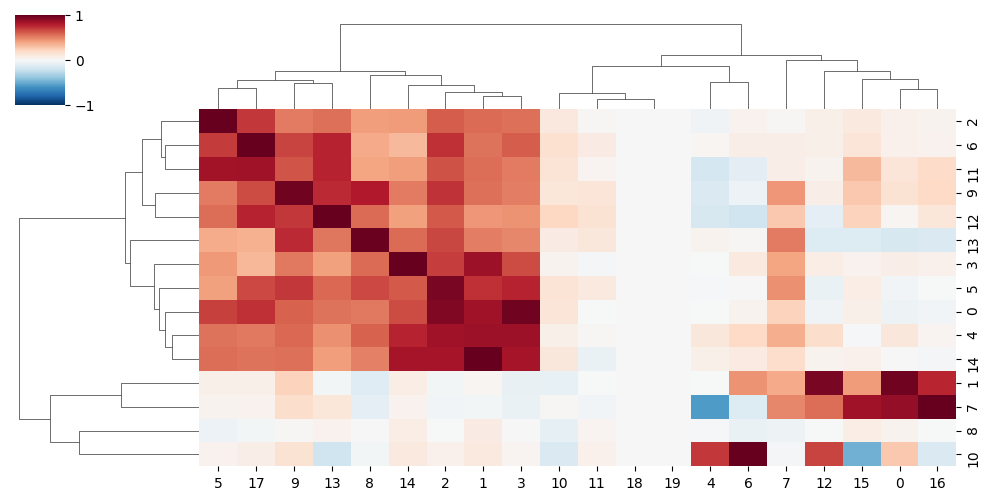

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn import datasets
from nilearn.decomposition import DictLearning
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import seaborn as sns
from scipy.stats import pearsonr
import pandas as pd

class ComponentCorrelationVisualizer:
    """
    A class used to visualize the correlation between components of fMRI data.

    Attributes:
    -----------
    n_low_order : int
        Number of low order components.
    n_high_order : int
        Number of high order components.
    ...

    Methods:
    --------
    fetch_data():
        Fetch the ADHD200 resting-state fMRI dataset.
    ...
    """

    def __init__(self, n_low_order, n_high_order):
        """
        Initialize the ComponentCorrelationVisualizer with the number of components for decomposition.

        Parameters:
        -----------
        n_low_order : int
            Number of low order components to decompose.
        n_high_order : int
            Number of high order components to decompose.
        """
        self.n_low_order = n_low_order
        self.n_high_order = n_high_order

    def fetch_data(self):
        """ Fetch the ADHD200 resting-state fMRI dataset. """
        n_subjects = 1
        adhd_dataset = datasets.fetch_adhd(n_subjects=n_subjects)
        self.func_filenames = adhd_dataset.func

    def perform_decomposition(self):
        """ Decompose the fetched fMRI data into specified number of components. """
        dict_learn_low = DictLearning(n_components=self.n_low_order, random_state=0, memory="nilearn_cache", memory_level=2)
        self.components_img_low = dict_learn_low.fit_transform(self.func_filenames)

        dict_learn_high = DictLearning(n_components=self.n_high_order, random_state=0, memory="nilearn_cache", memory_level=2)
        self.components_img_high = dict_learn_high.fit_transform(self.func_filenames)

    def compute_correlation_matrix(self):
        """ Compute the spatial correlations between two sets of components and store results. """
        self.correlation_matrix = np.zeros((self.n_low_order, self.n_high_order))
        self.p_values = np.ones((self.n_low_order, self.n_high_order))

        self.results = []

        for i in range(self.n_low_order):
            for j in range(self.n_high_order):
                data_low = self.components_img_low[0][..., i]
                data_high = self.components_img_high[0][..., j]
                correlation, p_value = pearsonr(data_low.ravel(), data_high.ravel())
                self.correlation_matrix[i, j] = correlation
                self.p_values[i, j] = p_value

                self.results.append({
                    'Low_Order_Component': i,
                    'High_Order_Component': j,
                    'Pearson_r': correlation,
                    'p_value': p_value
                })

        # Replace NaN or inf values in the correlation matrix with 0
        self.correlation_matrix = np.nan_to_num(self.correlation_matrix, nan=0.0, posinf=0.0, neginf=0.0)

    def export_results_to_csv(self, filename="correlation_results.csv"):
        """
        Export the computed correlation results to a CSV file.

        Parameters:
        -----------
        filename : str, optional
            The name of the CSV file (default is "correlation_results.csv").
        """
        df = pd.DataFrame(self.results)

        # Sort by p_value in ascending order
        self.df = df.sort_values(by='p_value')

        self.df.to_csv(filename, index=False)

    def plot_heatmap(self):
        """ Visualize the computed correlation matrix using a heatmap. """
        # Use a diverging colormap that transitions from red to blue
        diverging_cmap = plt.cm.RdBu_r

        # Plotting hierarchical clustering heatmap with the diverging colormap
        figsize = (10, 5)
        g = sns.clustermap(
            self.correlation_matrix,
            method="average",
            cmap=diverging_cmap,
            vmin=-1,
            vmax=1,
            annot=False,
            fmt=".2f",
            figsize=figsize,
        )

    def visualize_component_correlation(self):
        """
        Perform a complete visualization workflow: fetch data, decompose, compute correlations, plot heatmap, and export results.
        """
        self.fetch_data()
        self.perform_decomposition()
        self.compute_correlation_matrix()
        self.plot_heatmap()
        self.export_results_to_csv()

if __name__ == "__main__":
    n_low_order = int(input("Enter the number of low-order components: "))
    n_high_order = int(input("Enter the number of high-order components: "))
    visualizer = ComponentCorrelationVisualizer(n_low_order, n_high_order)
    visualizer.visualize_component_correlation()

In [16]:
pd.read_csv('/content/correlation_results.csv')

,Low_Order_Component,High_Order_Component,Pearson_r,p_value
0,6,17,0.999904,0.000000e+00
1,2,5,0.999743,4.675847e-288
2,3,14,0.999691,3.767784e-281
3,12,13,0.999654,7.870276e-277
4,10,6,0.998814,2.416886e-230
...,...,...,...,...
295,12,19,NaN,NaN
296,13,18,NaN,NaN
297,13,19,NaN,NaN
298,14,18,NaN,NaN


## No Clustering


Enter the number of components for the first decomposition: 15
Enter the number of components for the second decomposition: 20


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


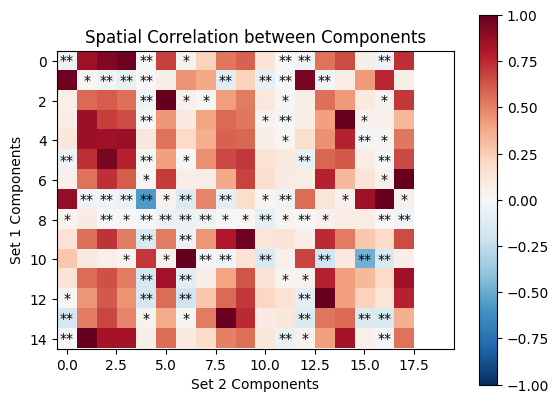

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn import datasets
from nilearn.decomposition import DictLearning

def fetch_data(n_subjects=1):
    """Fetch the ADHD200 resting-state fMRI dataset."""
    return datasets.fetch_adhd(n_subjects=n_subjects)

def decompose_data(n_components, func_filenames):
    """Decompose the data into a given number of components."""
    dict_learn = DictLearning(n_components=n_components, random_state=0, memory="nilearn_cache", memory_level=2)
    return dict_learn.fit_transform(func_filenames)

def compute_correlation(components_img_1, components_img_2):
    """Compute the spatial correlations between two sets of components."""
    n_comp_1, n_comp_2 = components_img_1[0].shape[-1], components_img_2[0].shape[-1]
    correlation_matrix = np.zeros((n_comp_1, n_comp_2))

    for i in range(n_comp_1):
        for j in range(n_comp_2):
            data_1, data_2 = components_img_1[0][..., i], components_img_2[0][..., j]
            correlation = np.corrcoef(data_1.ravel(), data_2.ravel())[0, 1]
            correlation_matrix[i, j] = correlation

    return correlation_matrix

def plot_heatmap(correlation_matrix):
    """Visualize the correlation matrix using a heatmap."""
    plt.imshow(correlation_matrix, cmap='RdBu_r', vmin=-1, vmax=1)

    rows, cols = correlation_matrix.shape
    for i in range(rows):
        for j in range(cols):
            text = ''
            if correlation_matrix[i, j] < 0.001:
                text = '**'
            elif correlation_matrix[i, j] < 0.05:
                text = '*'
            plt.text(j, i, text, ha='center', va='center', color='black')

    plt.colorbar()
    plt.xlabel("Set 2 Components")
    plt.ylabel("Set 1 Components")
    plt.title("Spatial Correlation between Components")
    plt.show()

if __name__ == "__main__":
    n_comp_set1 = int(input("Enter the number of components for the first decomposition: "))
    n_comp_set2 = int(input("Enter the number of components for the second decomposition: "))

    # Fetch the data
    func_filenames = fetch_data().func

    # Decompose data for both sets of components
    components_img_1 = decompose_data(n_comp_set1, func_filenames)
    components_img_2 = decompose_data(n_comp_set2, func_filenames)

    # Compute correlation matrix
    correlation_matrix = compute_correlation(components_img_1, components_img_2)

    # Plot the heatmap
    plot_heatmap(correlation_matrix)
